In [1]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json
#from utility_functions2 import *

In [2]:
warnings.filterwarnings('ignore', 'invalid value')
warnings.filterwarnings('ignore', 'No format')

In [3]:
hgg = ak.from_parquet('/scratch365/cmoore24/training/data/ecfs/hgg_ecfs.parquet')

In [4]:
qcd = ak.firsts(ak.from_parquet('/scratch365/cmoore24/training/data/ecfs/qcd_ecfs.parquet'))

In [5]:
hgg = hgg[ak.flatten(hgg.msoftdrop < 200)]
hgg = hgg[ak.flatten(hgg.msoftdrop > 40)]
hgg = hgg[ak.flatten(hgg.pt < 600)]
hgg = hgg[ak.flatten(hgg.pt > 450)]

In [6]:
qcd = qcd[qcd.msoftdrop < 200]
qcd = qcd[qcd.msoftdrop > 40]
qcd = qcd[qcd.pt < 600]
qcd = qcd[qcd.pt > 450]

In [7]:
mask = ak.ones_like(hgg[hgg.fields[0]], dtype='bool')
mask = ak.fill_none(mask, True)
for j in hgg.fields:
    if hgg[j].fields == []:
        mask = mask & (~ak.is_none(ak.nan_to_none(hgg[j])))
    else:
        for i in hgg[j].fields:
            mask = mask & (~ak.is_none(ak.nan_to_none(hgg[j][i])))
hgg = hgg[ak.flatten(mask)]

In [8]:
mask = ak.ones_like(qcd[qcd.fields[0]], dtype='bool')
mask = ak.fill_none(mask, True)
for j in qcd.fields:
    if qcd[j].fields == []:
        mask = mask & (~ak.is_none(ak.nan_to_none(qcd[j])))
    else:
        for i in qcd[j].fields:
            mask = mask & (~ak.is_none(ak.nan_to_none(qcd[j][i])))
qcd = qcd[mask]

In [9]:
with open('/scratch365/cmoore24/training/hgg/binary/ecfs_project/ratios_equal0.pkl', 'rb') as f:
    ecf_list0 = pickle.load(f)
with open('/scratch365/cmoore24/training/hgg/binary/ecfs_project/ratios_equal1.pkl', 'rb') as f:
    ecf_list1 = pickle.load(f)
with open('/scratch365/cmoore24/training/hgg/binary/ecfs_project/ratios_equal2.pkl', 'rb') as f:
    ecf_list2 = pickle.load(f)

In [10]:
with open('ratios0.pkl', 'rb') as f:
    ecf_list0 = pickle.load(f)
with open('ratios1.pkl', 'rb') as f:
    ecf_list1 = pickle.load(f)
with open('ratios2.pkl', 'rb') as f:
    ecf_list2 = pickle.load(f)

In [11]:
with open('/scratch365/cmoore24/training/hgg/binary/ecfs_project/ratios_equal0.json', 'r') as f:
    ecf_json0 = json.load(f)
with open('/scratch365/cmoore24/training/hgg/binary/ecfs_project/ratios_equal1.json', 'r') as f:
    ecf_json1 = json.load(f)
with open('/scratch365/cmoore24/training/hgg/binary/ecfs_project/ratios_equal2.json', 'r') as f:
    ecf_json2 = json.load(f)

In [12]:
with open('ratios0.json', 'r') as f:
    ecf_json0 = json.load(f)
with open('ratios1.json', 'r') as f:
    ecf_json1 = json.load(f)
with open('ratios2.json', 'r') as f:
    ecf_json2 = json.load(f)

In [13]:
ecf_list = ecf_list0 + ecf_list1 + ecf_list2
ecf_json = (ecf_json0 | ecf_json1) | ecf_json2

In [14]:
ecf_list[9]

'1e3^1.0/1e2^1.0**1.0'

In [15]:
# use_ecf = ecf_list[2089]
use_ecf = 	'4e5^0.5/1e3^2.5**0.8'
use_ecf

'4e5^0.5/1e3^2.5**0.8'

In [16]:
index = ecf_json[use_ecf]['index']
index

3660

In [17]:
model = f'/scratch365/cmoore24/training/hgg/binary/ecfs_project/outputs/models/traced_model{index}.pt'
# model = f'/scratch365/cmoore24/training/hgg/binary/ecfs_project/traced_model_test.pt'

In [18]:
scaler = f'/scratch365/cmoore24/training/hgg/binary/ecfs_project/outputs/scalers/scaler{index}.pkl'
# scaler = f'/scratch365/cmoore24/training/hgg/binary/ecfs_project/scaler_test.pkl'

with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

In [19]:
dash = use_ecf.find('/')
asterisk = use_ecf.find('*')
numerator = use_ecf[:dash]
print(numerator)
denominator = use_ecf[dash+1:asterisk]
print(denominator)
exponent = use_ecf[asterisk+2:]
print(exponent)

4e5^0.5
1e3^2.5
0.8


In [20]:
num_hgg = hgg.ECFs[numerator]
den_hgg = hgg.ECFs[denominator]
hgg_ecf = num_hgg/(den_hgg**float(exponent))
nan_mask = np.isnan(hgg_ecf)
hgg_ecf = hgg_ecf[~nan_mask]


In [21]:
hgg_sub_array = ak.zip({
                        'ecf': hgg_ecf, 
                        # 'ecf': hgg.d2b1,
                        'msoftdrop': hgg.msoftdrop[~nan_mask],
                        },
                       depth_limit=1,
                      )

In [22]:
num_qcd = qcd.ECFs[numerator]
den_qcd = qcd.ECFs[denominator]
qcd_ecf = num_qcd/(den_qcd**float(exponent))
nan_mask = np.isnan(qcd_ecf)
qcd_ecf = qcd_ecf[~nan_mask]

In [23]:
qcd_sub_array = ak.zip({
                        'ecf': qcd_ecf, 
                        # 'ecf': qcd.d2b1,
                        'msoftdrop': qcd.msoftdrop[~nan_mask],
                        },
                       depth_limit=1,
                      )

In [24]:
class EnergyCorrelatorFunctionTagger(torch_wrapper):
    def prepare_awkward(self, events, scaler):
        fatjets = events

        imap = {
            'vars': {
                f'{use_ecf}': fatjets.ecf,
            },
        }

        retmap = {
            k: ak.concatenate([x[:, np.newaxis] for x in imap[k].values()], axis=1)
            for k in imap.keys()
        }
        x = ak.values_astype(scaler.transform(retmap['vars']), "float32")
        return (x,), {}

In [25]:
tagger = EnergyCorrelatorFunctionTagger(model)

In [26]:
hgg_scores = tagger(hgg_sub_array, scaler)[:,0]

In [27]:
qcd_scores = tagger(qcd_sub_array, scaler)[:,0]

In [28]:
up = max(ak.max(hgg_scores), ak.max(qcd_scores))
up

1.1107526

In [29]:
down = min(ak.min(hgg_scores), ak.min(qcd_scores))
down

-3.2379699

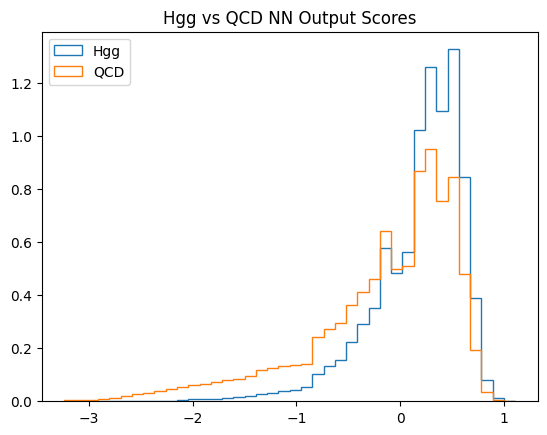

In [30]:
pltrange = (down, up)
plt.hist(hgg_scores, bins=40, histtype='step', label='Hgg', density=True, range=pltrange)
plt.hist(qcd_scores, bins=40, histtype='step', label='QCD', density=True, range=pltrange)
plt.title(f'Hgg vs QCD NN Output Scores')
plt.legend()
plt.show()

In [31]:
bkg_zeros = ak.zeros_like(qcd_scores)
sig_ones = ak.ones_like(hgg_scores)
combined = ak.concatenate([qcd_scores,hgg_scores])
combined_truth = ak.concatenate([bkg_zeros, sig_ones])

In [32]:
fpr, tpr, thresholds = roc_curve(combined_truth, combined)
roc_auc = auc(fpr, tpr)

In [33]:
hrange=(np.floor(ak.min(qcd_scores)), np.ceil(ak.max(qcd_scores)))
hrange

(-4.0, 2.0)

In [34]:
hgg_hist = np.histogram(hgg_scores, bins=20,
                range=hrange
                )
qcd_hist = np.histogram(qcd_scores, bins=20, 
                 range=hrange
                )

In [35]:
sig_sums = []
for i in range(len(hgg_hist[0])+1):
    sig_sums.append(sum(hgg_hist[0][len(hgg_hist[0])-i:]))

bkg_sums = []
for i in range(len(qcd_hist[0])+1):
    bkg_sums.append(sum(qcd_hist[0][len(qcd_hist[0])-i:]))

In [36]:
sig_ratios = []
for i in sig_sums:
    sig_ratios.append(i/sig_sums[-1])
bkg_ratios = []
for i in bkg_sums:
    bkg_ratios.append(i/bkg_sums[-1])

In [37]:
wp_ratios = {}
for i in range(len(hgg_hist[1])):
    wp_ratios[str(hgg_hist[1][-i-1])] = [sig_ratios[i], bkg_ratios[i]]

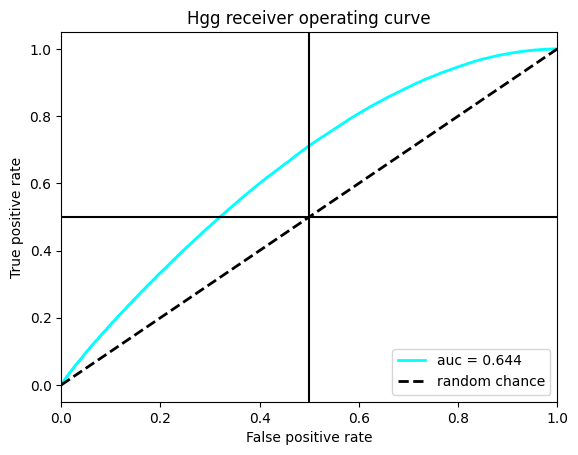

In [38]:
plt.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
plt.xlim([0, 1.0])
#     ax.set_ylim([1e-5, 1.0])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(f"Hgg receiver operating curve")
plt.legend(loc="lower right")
plt.axvline(x=0.5, color='black')
plt.axhline(y=0.5, color='black')
# for i in wp_ratios:
#     plt.plot(wp_ratios[i][1], wp_ratios[i][0], 'o', label=f'WP = {str(i)}')
#plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [251]:
def get_cut(qcd_scores, break_val):
    hrange=(ak.min(qcd_scores), ak.max(qcd_scores))
    proportion=1.0
    i = 0
    while proportion > 0.70:
        qcd_hist = np.histogram(qcd_scores, bins=100000, 
                     range=hrange
                    )
        largest_bin_indices = np.argsort(qcd_hist[0])[-2:]
        largest_bin_vals = qcd_hist[1][largest_bin_indices]
        hrange = (largest_bin_vals[0], ak.max(qcd_scores))
        proportion = sum(qcd_hist[0])/len(qcd_scores)
        print(proportion)
        i += 1
        if i > break_val:
            break
    cumulative_distribution = np.cumsum(qcd_hist[0][min(largest_bin_indices):max(largest_bin_indices)])
    total_count = cumulative_distribution[-1]
    half_count = total_count / 2
    median_bin_index = np.where(cumulative_distribution >= half_count)[0][0]
    cut = qcd_hist[1][median_bin_index]
    return cut

In [252]:
cut = get_cut(hgg_scores, 49)
cut

1.0
0.5836158790704246


0.3135699927806854

In [253]:
ak.max(hgg_scores)

1.0578351

In [254]:
#cut = 0.4

In [255]:
mask = ~((qcd_scores > cut))
qcd_cut_msd = qcd_sub_array.msoftdrop[mask]
qcd_fail_hist = hist.Hist.new.Reg(40, 40, 200, name='msd', label='QCD MSD').Weight()
qcd_fail_hist.fill(msd=qcd_cut_msd);

mask = ~((hgg_scores > cut))
hgg_cut_msd = ak.flatten(hgg_sub_array.msoftdrop[mask])
hgg_fail_hist = hist.Hist.new.Reg(40, 40, 200, name='msd', label='Hgg MSD').Weight()
hgg_fail_hist.fill(msd=hgg_cut_msd);

In [256]:
len(qcd_cut_msd)

1538898

In [257]:
mask = ((qcd_scores > cut))
qcd_cut_msd = qcd_sub_array.msoftdrop[mask]
qcd_pass_hist = hist.Hist.new.Reg(40, 40, 200, name='msd', label='QCD MSD').Weight()
qcd_pass_hist.fill(msd=qcd_cut_msd);

mask = ((hgg_scores > cut))
hgg_cut_msd = ak.flatten(hgg_sub_array.msoftdrop[mask])
hgg_pass_hist = hist.Hist.new.Reg(40, 40, 200, name='msd', label='Hgg MSD').Weight()
hgg_pass_hist.fill(msd=hgg_cut_msd);

In [258]:
len(qcd_cut_msd)

607021

In [259]:
with open('../jsons/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)
with open('../jsons/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [260]:
scale = ((44.99*(xsecs['hgg']*0.0817*1000))/totals['hgg'])
hgg_pass_hist.view(flow=True)[:] *= scale
hgg_fail_hist.view(flow=True)[:] *= scale

In [261]:
scale = ((44.99*(xsecs['qcd']['qcd_470to600']*1000))/totals['qcd']['470to600'])
qcd_pass_hist.view(flow=True)[:] *= scale
qcd_fail_hist.view(flow=True)[:] *= scale

In [262]:
total_qcd_hist = qcd_pass_hist + qcd_fail_hist
total_hgg_hist = hgg_pass_hist + hgg_fail_hist

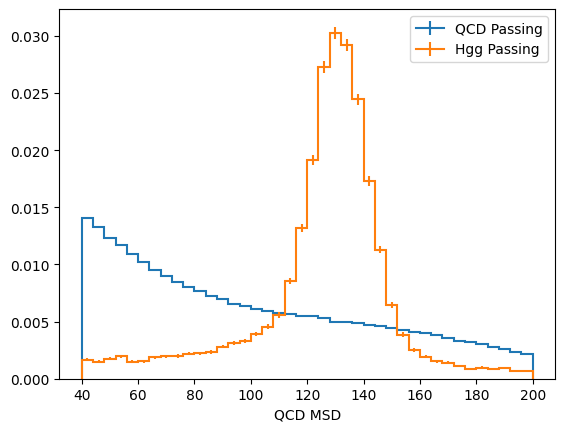

In [274]:
qcd_pass_hist.plot1d(density=True, label='QCD Passing')
#qcd_fail_hist.plot1d(density=True, label='QCD Failing')
#total_qcd_hist.plot1d(density=True, label='QCD Total')

hgg_pass_hist.plot1d(density=True, label='Hgg Passing')
#hgg_fail_hist.plot1d(density=True, label='Hgg Failing')
#total_hgg_hist.plot1d(density=True, label='Hgg Total')

plt.legend()
plt.show()

In [264]:
hgg_pass_hist

Hist(Regular(40, 40, 200, name='msd', label='Hgg MSD'), storage=Weight()) # Sum: WeightedSum(value=18.4662, variance=0.0133631)

In [265]:
total_hgg_hist

Hist(Regular(40, 40, 200, name='msd', label='Hgg MSD'), storage=Weight()) # Sum: WeightedSum(value=40.979, variance=0.0296546)

In [269]:
sorsb = hgg_pass_hist.values() / np.sqrt(hgg_pass_hist.values() + qcd_pass_hist.values())

In [270]:
np.sqrt(np.sum(sorsb**2))

0.039671668583758486

In [272]:
sum(qcd_pass_hist.values()), sum(total_qcd_hist.values())

(743719.7044853303, 2629171.387035137)

In [273]:
sum(qcd_pass_hist.values())/sum(total_qcd_hist.values())* 100

28.287227989500064

In [89]:
sculpt_metric = sum(abs(total_qcd_hist.density() - qcd_pass_hist.density()))

In [90]:
sum(total_qcd_hist[30:].density() - qcd_pass_hist[30:].density()) # Look a

1.0408340855860843e-17

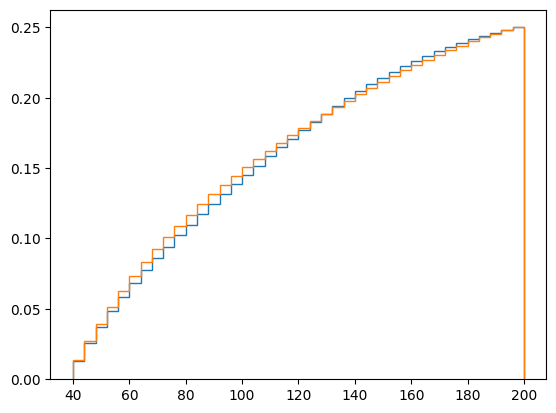

In [91]:
fig, ax = plt.subplots()

ax.stairs(np.cumsum(total_qcd_hist.density()), edges=total_qcd_hist.axes[0].edges);
ax.stairs(np.cumsum(qcd_pass_hist.density()), edges=qcd_pass_hist.axes[0].edges);

In [92]:
abs(np.cumsum(total_qcd_hist.density() * 4) - np.cumsum(qcd_pass_hist.density() * 4)).max()

0.028857023822828842

In [93]:
sculpt_metric

0.02050888633452582

In [94]:
roc_auc

0.6444098419510024